# Training Domain-informed Neural Network model

A Domain-informed Neural Network (DiNN) model is implemented and trained on simulated S2 patterns using TensorFlow.

Position of photosensors are loaded from [straxen](https://github.com/XENONnT/straxen)

In [1]:
import numpy as np

import straxen

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #select GPU, -1 means use CPU

from tensorflow.keras.models import Sequential
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

tf.__version__

'2.3.1'

In [2]:
from DiNN import GraphConstrained, FG_Squircular_to_disk

## Simulate S2 patterns using empirical LCE model 

In [3]:
# Basic Config 
N_PATTERNS = int(1e6)
TPC_RADIUS = 66.4 # cm
N_ELECTRONS = 100 # not used for training
SECONDARY_YIELD = 350 # PE/e
SPE_RESOLUTION = 0.05 # 5%


# parameters for LCE model
BEST_FIT = (1.17985513e-02,  # lce_0
            2.39099129e+00,  # p
            1.03367572e+01,  # d
            -6.77171875e-07, # a
            9.86493009e-05)  # b


# photosensor positions
PMT_POSITIONS = np.array(straxen.pmt_positions().loc[:, ('x', 'y')].values)[0:253]

In [4]:
# Empirical LCE model

def lce_model(rho, lce_0, p, d, a, b):
    """Model of the light collection efficiency
    """
    return lce_0 * (1 - b)/(1 + (rho/d)**2)**p + a * rho + b

In [7]:
# utilities for simulating S2 patterns

def get_random_points_in_circle(n_patterns = N_PATTERNS,
                                tpc_radius = TPC_RADIUS):
    """Get random points in a circle of radius tpc_radius
    
    Returns array (n_patterns, 2)
    """
    r = tpc_radius * np.sqrt(np.random.uniform(size=n_patterns))
    theta = 2 * np.pi * np.random.uniform(size=n_patterns)
    return np.vstack((r * np.cos(theta), r * np.sin(theta))).T

def get_hitpatterns(n_patterns = N_PATTERNS, 
                    n_electrons = N_ELECTRONS,
                    secondary_yield = SECONDARY_YIELD,
                    spe_resolution = SPE_RESOLUTION,
                    sensor_positions = PMT_POSITIONS,
                    fluctuate = True):
    """
    Simulate S2 patterns.
    
    Returns tuple (true S2 position, S2 patterns)
    """
    points = get_random_points_in_circle(n_patterns) # (n_patterns, 2), cm
    
    n_pmts = sensor_positions.shape[0]
    n_points = points.shape[0]
    
    # Compute all combinations of points and PMT positions
    points_big = np.repeat(points, n_pmts, axis=0).reshape(-1, 2)
    pmt_positions_big = np.tile(PMT_POSITIONS.flatten(), n_points).reshape(-1, 2)
    distances = np.sqrt(np.sum(np.power(points_big - pmt_positions_big,
                                        2),
                               axis=1).reshape(n_points,
                                               n_pmts))
    # distances[1, 2] # first index is point, second index is pmt
    
    
    lce = lce_model(distances, *BEST_FIT) # (n_points, n_pmts)
    
    if fluctuate == False:
        return lce
    
    lce *= N_ELECTRONS * SECONDARY_YIELD
    
    return (points, np.random.poisson(lce) * np.random.normal(loc=1,
                                                     scale=spe_resolution,
                                                     size=lce.shape).reshape(lce.shape))

In [18]:
N_ELECTRONS = np.random.uniform(1,2000, size = 1000000).reshape(-1,1)
true, hit_patterns = get_hitpatterns(fluctuate=True)

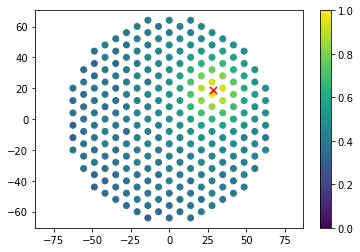

In [19]:
index = 7

plt.scatter(*PMT_POSITIONS.T, c=hit_patterns[index],
           norm=colors.LogNorm(vmin=1,
                                 vmax=hit_patterns[index].max())
           )

plt.scatter(true[index,0], true[index,1], color = "red", marker = "x", s = 50)
plt.xlim(-TPC_RADIUS, TPC_RADIUS)
plt.ylim(-TPC_RADIUS, TPC_RADIUS)
plt.axis("equal")
plt.colorbar()

In [20]:
# normalize

patterns = hit_patterns[:,:253]
patterns = patterns / np.max(patterns, axis = 1).reshape(-1, 1)
patterns = patterns.reshape(-1,253)
patterns.shape

(1000000, 253)

In [21]:
# spilting into training/validation/testing set

train_size = 500000
test_size = 100000

positions = true[:,0:2]

x_train_pos = patterns[:train_size]
y_train_pos = positions[:train_size]
x_val_pos = patterns[train_size: train_size + test_size]
y_val_pos = positions[train_size: train_size + test_size]
x_test_pos = patterns[train_size + test_size: train_size + 2 * test_size]
y_test_pos = positions[train_size + test_size: train_size + 2 * test_size]


## Build DiNN model

In [22]:
# utilities for assigning positions to neurons in graph constraint layers

def radialarrange(radius, number, start = 0):
    angle = 2 * np.pi * np.linspace(0, 1., number, endpoint = False) + start * np.pi
    points = np.zeros((number, 2))
    points[:,0] = np.cos(angle) * radius
    points[:,1] = np.sin(angle) * radius
    return points

def adj_from_coordinate(points1, points2, threshold = 20.):
    from sklearn.metrics import euclidean_distances
    points = np.concatenate([points1, points2])
    distances = euclidean_distances(points)
    distances[distances <= threshold] = 1.
    distances[distances > threshold] = 0.
    adj = distances[:len(points1), -len(points2):]
    return adj

def layer_points(PMT_number, r_distance, ring_num):
    layer_radius = [ i * r_distance for i in range(ring_num)]
    points = np.zeros((0,2))
    for i in range(ring_num):
        points = np.concatenate([points, radialarrange(layer_radius[i], PMT_number[i], start = 0)])
    
    return points

In [23]:
# generate adjacency matrix for each layer

pmt_positions = straxen.pmt_positions()[['x', 'y']].to_numpy()

PMT_number = [1, 6, 12, 18, 24, 30, 36, 42, 48]
R_distances = [8., 9., 10.5, 13, 16, 21]
ring_num = [9, 8, 7, 6, 5, 4]

points = [pmt_positions[:253,:],]
for i in range(len(ring_num)):
    points.append(layer_points(PMT_number, R_distances[i], ring_num[i]))
    
adj = []
for i in range(len(ring_num)):
    adj.append(adj_from_coordinate(points[i], points[i + 1], threshold = 30.))

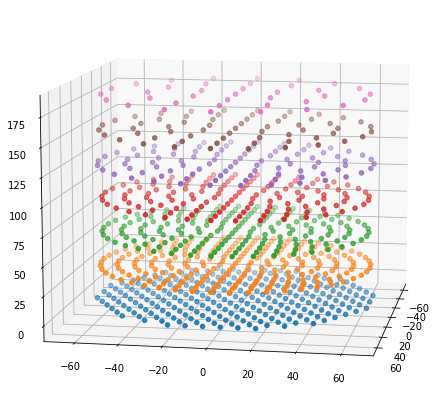

In [27]:
# Show the assigned positions along with the top photosensor array
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (7, 9))
ax = fig.add_subplot(111, projection='3d')

for i,d in enumerate(points):
    ax.scatter(d[:,0], d[:,1], zs = i * 30.)
    
    
ax.azim = 10
ax.dist = 8
ax.elev = 10    
plt.show()

In [24]:
learning_rate = 5e-3


# define the model
X_in = Input(shape = (253,)) 


X = GraphConstrained(adj = adj[0], activation='elu')(X_in)
X = GraphConstrained(adj = adj[1], activation='elu')(X)
X = GraphConstrained(adj = adj[2], activation='elu')(X)
X = GraphConstrained(adj = adj[3], activation='elu')(X)
X = GraphConstrained(adj = adj[4], activation='elu')(X)
X = GraphConstrained(adj = adj[5], activation='elu')(X)
X = Dense(20, activation = 'elu')(X)
X = Dense(2, activation='tanh')(X)
    
output = FG_Squircular_to_disk(67.)(X) # map to circle of 67 cm

model = Model(inputs=X_in, outputs=output)
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer = optimizer,
              loss ='mean_squared_error')

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 253)]             0         
_________________________________________________________________
graph_constrained_6 (GraphCo (None, 217)               55118     
_________________________________________________________________
graph_constrained_7 (GraphCo (None, 169)               36842     
_________________________________________________________________
graph_constrained_8 (GraphCo (None, 127)               21590     
_________________________________________________________________
graph_constrained_9 (GraphCo (None, 91)                11648     
_________________________________________________________________
graph_constrained_10 (GraphC (None, 61)                5612      
_________________________________________________________________
graph_constrained_11 (GraphC (None, 37)               

## Training

In [25]:
batch_size = 500
epochs = 250

validation_data = (x_val_pos , y_val_pos)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=0.0001)

hist = model.fit(x_train_pos,
          y_train_pos,
          batch_size=batch_size,
          validation_data=validation_data,
          epochs=epochs,
                 callbacks=[reduce_lr,]
          )

Epoch 1/250
1000/1000 [==============================] - 7s 7ms/step - loss: 16.6227 - val_loss: 0.7282
Epoch 2/250
1000/1000 [==============================] - 7s 7ms/step - loss: 0.6159 - val_loss: 0.5377
Epoch 3/250
1000/1000 [==============================] - 7s 7ms/step - loss: 0.3360 - val_loss: 0.1940
Epoch 4/250
1000/1000 [==============================] - 7s 7ms/step - loss: 0.2540 - val_loss: 0.1719
Epoch 5/250
1000/1000 [==============================] - 7s 7ms/step - loss: 0.2264 - val_loss: 0.4401
Epoch 6/250
1000/1000 [==============================] - 7s 7ms/step - loss: 0.2164 - val_loss: 0.3283
Epoch 7/250
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1707 - val_loss: 0.1475
Epoch 8/250
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1684 - val_loss: 0.2498
Epoch 9/250
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1497 - val_loss: 0.1001
Epoch 10/250
1000/1000 [==============================] - 7s 7ms/step - 

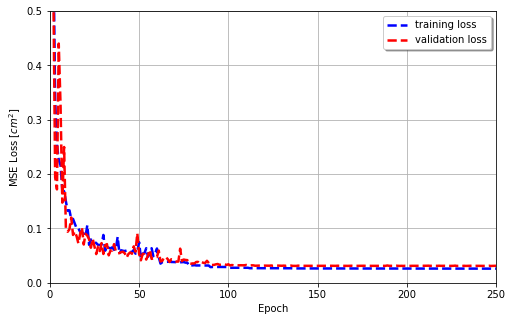

In [28]:
x = np.linspace(1, epochs, epochs)
val_loss = hist.history['val_loss']
loss = hist.history['loss']


fig_sig= plt.figure(figsize = (8,5))

#--------------------------------------------------------------------->
plt.plot(x,loss,label='training loss', color='blue', linestyle = '--', lw=2.5)
plt.plot(x,val_loss,label='validation loss', color='red', linestyle = '--', lw=2.5)
#-------------------------------------------------------------------->
# plt.title(r'Fig 3: Training Process', fontsize = 20)
plt.xlim(0,epochs)
plt.ylim(0, 0.5)

plt.xlabel('Epoch')
plt.ylabel('MSE Loss [$cm^2$]')
plt.grid(True)

legend = plt.legend(loc='upper right', shadow=True)

plt.show()

In [29]:
pred_pos = model.predict(x_test_pos)
test_pos = np.array(y_test_pos).reshape(-1,2)

In [53]:
pred_pos = np.array(pred_pos).reshape(-1,2)
test_pos = np.array(y_test_pos).reshape(-1,2)

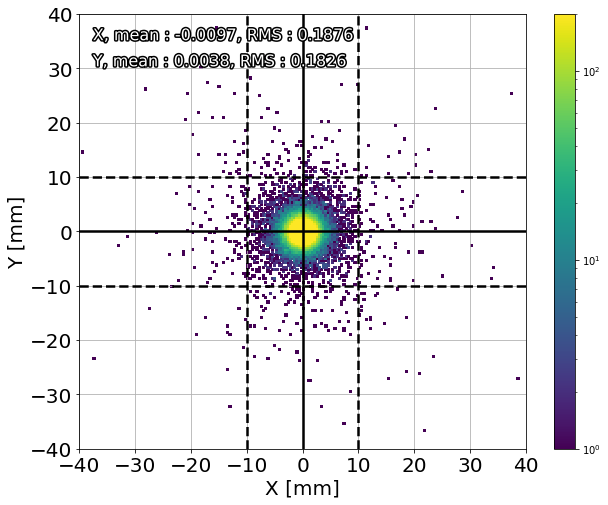

In [34]:
import matplotlib.patheffects as path_effects

fig_sig= plt.figure(figsize = (10,8))

#--------------------------------------------------------------------->
plt.hist2d((pred_pos[:,0]-test_pos[:,0]) * 10.,  (pred_pos[:,1]-test_pos[:,1]) * 10., range=((-40, 40), (-40, 40)), bins=(200, 200), 
           norm=colors.LogNorm( vmin=1, vmax=200))
plt.colorbar()

#-------------------------------------------------------------------->

plt.xlim(-40, 40)
plt.ylim(-40, 40)

plt.xlabel(r'X [mm]', fontsize =20)
plt.ylabel(r'Y [mm]', fontsize =20)
plt.grid(True)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.axvline(0, color='black', linestyle='-', linewidth = 2.5)
plt.axvline(-10, color='black', linestyle='--', linewidth = 2.5)
plt.axvline(10, color='black', linestyle='--', linewidth = 2.5)

plt.axhline(0, color='black', linestyle='-', linewidth = 2.5)
plt.axhline(-10, color='black', linestyle='--', linewidth = 2.5)
plt.axhline(10, color='black', linestyle='--', linewidth = 2.5)

bias = np.sum(test_pos-pred_pos,axis = 0) / len(y_test_pos)
rms = np.std(test_pos-pred_pos,axis = 0)

text_X= plt.text(0.03,0.95,"X, mean : %0.4f, RMS : %0.4f"%(bias[0],rms[0] ), 
         transform = plt.gca().transAxes, ha = "left", va="center" , fontsize=16, c="w")
text_X.set_path_effects([path_effects.Stroke(linewidth=3, foreground='k'),
                       path_effects.Normal()])
text_Y=plt.text(0.03,0.89,"Y, mean : %0.4f, RMS : %0.4f"%(bias[1],rms[1] ), 
         transform = plt.gca().transAxes, ha = "left", va="center" , fontsize=16, c="w")
text_Y.set_path_effects([path_effects.Stroke(linewidth=3, foreground='k'),
                       path_effects.Normal()])

plt.show()